# Capstone 2 : Exploratory Data Analysis

## Recall, at the end of the Data Wrangling notebook we left off with 
    datapath = '../data/processed'
    save_file(data15clean, 'clean15.csv', datapath)
    
## as our cleaned data.

The feature we will be focusing on will be the type of pitch thrown with a target of minimizing the success of the opposing team. For now I decided to focus on starting pitchers as they provide more data and are typically required to have a more diverse pitch repoitoire than relief pitchers who only pitch for an inning or 2. 

The data will be acquired from https://www.kaggle.com/pschale/mlb-pitch-data-20152018?select=pitches.csv
which was scraped from  http://gd2.mlb.com/components/game/mlb/.


# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

In [3]:
import statsmodels.api as sm # This imports statsmodels (uses R style formulas with pd support. 
#https://www.statsmodels.org/stable/index.html)
from statsmodels.graphics.api import abline_plot # Plots a line given slope & intercept
#https://www.statsmodels.org/devel/generated/statsmodels.graphics.regressionplots.abline_plot.html
from sklearn.metrics import mean_squared_error, r2_score # Calculates mse & r^2 score.
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
from sklearn.model_selection import train_test_split # splits the data into train & test sets.
#uses X-train, X-test, y-train, y-test return format
from sklearn import linear_model, preprocessing # creates & performs OLS regression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
#preprocessing is used for scaling
#https://scikit-learn.org/stable/modules/preprocessing.html
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [4]:
#from sklearn.linear_model import
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [5]:
#missing values function
def missing(df):
    '''Takes dataframe as argument, 
    returns count and % of missing values for each column'''
    import pandas as pd
    miss = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
    miss.columns = ['count','%']
    return miss.sort_values(by = ['count'], ascending = False)

In [6]:
filepath = '../data/processed/clean15.csv'

In [7]:
data = pd.read_csv(filepath)

### Now lets use a few standard pandas dataframe methods to review the properties of our cleaned data

In [8]:
data.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,FF,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,CU,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [9]:
#double check that we dont have any missing values
missing(data)

,count,%
ab_id,0,0.0
batter_id,0,0.0
on_2b,0,0.0
on_1b,0,0.0
pitch_num,0,0.0
outs,0,0.0
s_count,0,0.0
b_count,0,0.0
b_score,0,0.0
pitch_type,0,0.0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21602 entries, 0 to 21601
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ab_id       21602 non-null  int64  
 1   batter_id   21602 non-null  int64  
 2   event       21602 non-null  object 
 3   g_id        21602 non-null  int64  
 4   inning      21602 non-null  int64  
 5   o           21602 non-null  int64  
 6   p_score     21602 non-null  int64  
 7   p_throws    21602 non-null  object 
 8   pitcher_id  21602 non-null  int64  
 9   stand       21602 non-null  object 
 10  top         21602 non-null  bool   
 11  id          21602 non-null  int64  
 12  last_name   21602 non-null  object 
 13  date        21602 non-null  object 
 14  type        21602 non-null  object 
 15  pitch_type  21602 non-null  object 
 16  b_score     21602 non-null  float64
 17  b_count     21602 non-null  float64
 18  s_count     21602 non-null  float64
 19  outs        21602 non-nul

In [15]:
#data.describe()

In [16]:
data.corr()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,1.000000,0.066781,0.999990,0.031528,0.025075,-0.038446,-0.080594,-0.029842,-0.080594,-0.011220,-0.004679,0.017584,0.016263,0.013609,-0.023364,0.004234,-0.001584
batter_id,0.066781,1.000000,0.066853,0.015528,-0.015304,0.030050,-0.032001,0.013836,-0.032001,-0.011592,0.013114,0.011350,-0.016523,0.011228,-0.017507,-0.011000,-0.001280
g_id,0.999990,0.066853,1.000000,0.031366,0.025007,-0.039017,-0.080589,-0.030112,-0.080589,-0.011665,-0.004671,0.017591,0.016162,0.013605,-0.023310,0.004133,-0.001563
inning,0.031528,0.015528,0.031366,1.000000,-0.024359,0.463773,-0.038845,-0.026315,-0.038845,0.247558,0.002325,-0.002908,-0.015481,0.000387,-0.016580,0.003676,-0.005271
o,0.025075,-0.015304,0.025007,-0.024359,1.000000,-0.002036,-0.016596,0.008393,-0.016596,0.029826,-0.028491,0.023074,0.870840,-0.011721,0.131614,0.124524,0.077002
p_score,-0.038446,0.030050,-0.039017,0.463773,-0.002036,1.000000,-0.022190,-0.120106,-0.022190,0.127076,0.004397,0.006752,0.005561,0.008727,-0.020935,0.023407,0.020093
pitcher_id,-0.080594,-0.032001,-0.080589,-0.038845,-0.016596,-0.022190,1.000000,-0.021117,1.000000,0.008959,-0.015018,0.021704,-0.010693,0.013850,0.007673,-0.000672,-0.012939
top,-0.029842,0.013836,-0.030112,-0.026315,0.008393,-0.120106,-0.021117,1.000000,-0.021117,-0.029726,0.000666,0.007605,0.009754,0.009253,0.001246,-0.014769,0.005076
id,-0.080594,-0.032001,-0.080589,-0.038845,-0.016596,-0.022190,1.000000,-0.021117,1.000000,0.008959,-0.015018,0.021704,-0.010693,0.013850,0.007673,-0.000672,-0.012939
b_score,-0.011220,-0.011592,-0.011665,0.247558,0.029826,0.127076,0.008959,-0.029726,0.008959,1.000000,0.016208,-0.025028,0.059144,-0.008264,0.050281,0.081191,0.074265


## Broad Strategies moving forward


We can try a couple different methods, one looking at correlating features for a given pitch type, and the other replacing the pitch type with integer values so we can include it in our correlation calculation. 
#### We can also try a chi-square test or multi-log regrerssion to compare categorical and continuous variables




# After doing some initial EDA, a few extra changes seem to be in order (that could be considered part of the data wrangling process). 

We are going to add a column that gives the count in format (balls, strikes) as one variable. This will be added in addition to the b_count and s_count features already present. 

The plots below demonstrate how the distribution of pitch types vary depending on the count. 

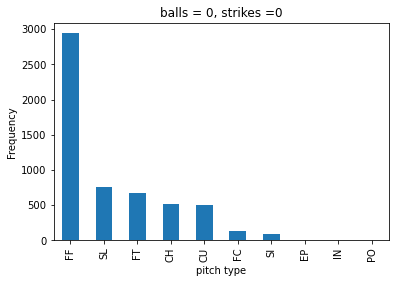

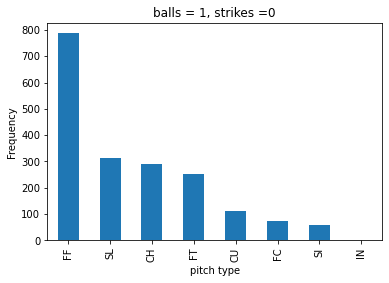

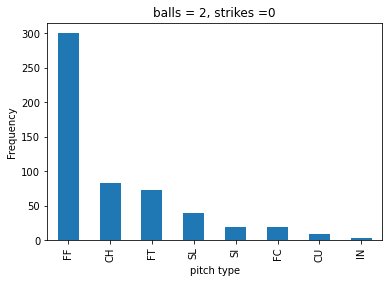

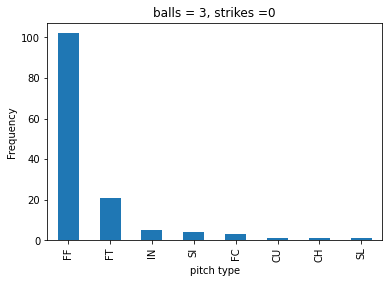

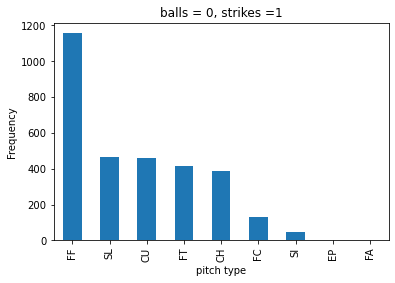

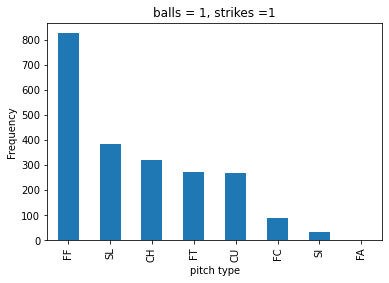

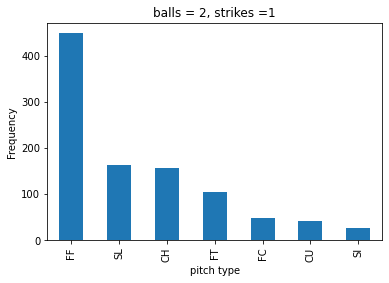

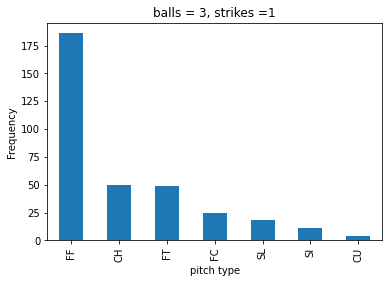

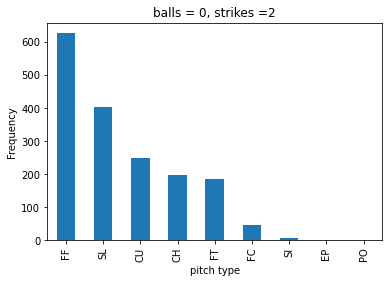

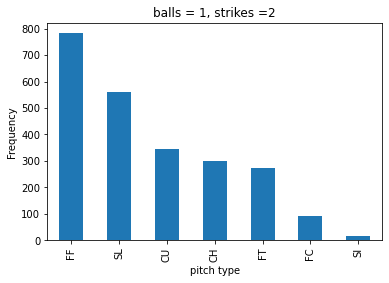

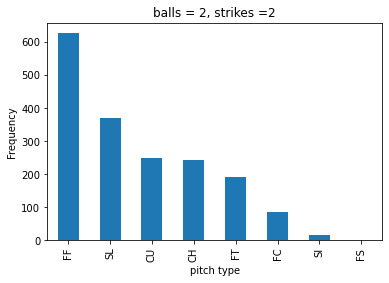

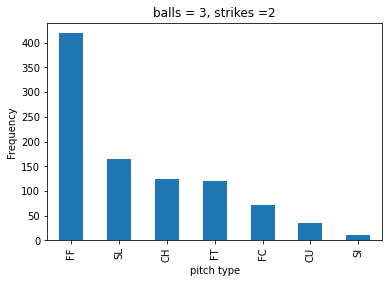

In [17]:
data15clean=data
#plots that show the distribution of pitches depending on the balls and strikes 
for i in range(3):
    for j in range(4):
        plt.figure()
        data15clean[np.logical_and(data15clean.loc[:, 's_count'].astype(int) == i ,\
                                   data15clean.loc[:, 'b_count'].astype(int) == j)]\
        .pitch_type.value_counts().plot(kind = 'bar')
        plt.xlabel('pitch type')
        plt.ylabel('Frequency')
        plt.title('balls = ' +str(j)+', strikes =' +str(i))
        plt.show()

In [18]:
data_counts = data
data_counts['b_s'] = list(zip(data.b_count.astype(int), data.s_count.astype(int)))
data_counts

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,b_s
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(0, 0)"
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,"(0, 1)"
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,"(0, 2)"
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,"(0, 2)"
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,CU,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,"(1, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21597,2015184080,150029,Strikeout,201502429,4,2,0,R,594798,R,...,FF,0.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,"(1, 2)"
21598,2015184080,150029,Strikeout,201502429,4,2,0,R,594798,R,...,CH,0.0,2.0,2.0,1.0,5.0,0.0,0.0,0.0,"(2, 2)"
21599,2015184081,519208,Groundout,201502429,4,3,0,R,594798,L,...,CH,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,"(0, 0)"
21600,2015184081,519208,Groundout,201502429,4,3,0,R,594798,L,...,CH,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,"(0, 1)"


### To simplify the analysis, we can get rid of pitches thrown only a few times

In [19]:
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
IN      13
EP       4
PO       2
FA       2
FS       1
Name: pitch_type, dtype: int64

### Now we will include a column where the pitch types are represented by integers

In [27]:
pitch_types = {'FF': 10, 'SL': 20, 'CU': 30, 'FT': 40, 'CH': 50, 'FC': 60, 'SI': 70}
data_counts = data_counts[data_counts.pitch_type.isin(pitch_types.keys())]
data_counts.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
Name: pitch_type, dtype: int64

In [21]:
#Find total number of pitches left in dataset
data_counts['p_type_number'] = data_counts.pitch_type.replace(pitch_types)
data_counts.shape[0]

<ipython-input-21-f84be204d717>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_counts['p_type_number'] = data_counts.pitch_type.replace(pitch_types)


21580

### Option to perhaps gain more strong correlations. 
We will add a column which just categorizes the pitch to whether it is a fastball (fourseam, twoseam, cutter) or a breaking ball (slider, curveball, changeup, sinker). 

In the Astros cheating scandal, they would only signal to the hitter whether or not the pitch was a fastball (as this would be the most important factor in a hitters timing)

Lets also make this a 0 vs 100 rating to see if the correlation signal is strengthened. 

In [29]:
pitch_types_fast = {'FF': 100, 'SL': 0, 'CU': 0, 'FT': 100, 'CH': 0, 'FC': 1, 'SI': 0}
data_counts = data_counts[data_counts.pitch_type.isin(pitch_types.keys())]
data_counts.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
Name: pitch_type, dtype: int64

In [30]:
data_counts['fast_or_slow'] = data_counts.pitch_type.replace(pitch_types_fast)
data_counts.shape[0]

21580

In [25]:
#data_counts.p_type_number

In [31]:
data_counts.corr()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,p_type_number,fast_or_slow
ab_id,1.000000,0.066903,0.999990,0.031160,0.025252,-0.038286,-0.079386,-0.030436,-0.079386,-0.010309,-0.004258,0.016936,0.016970,0.013513,-0.023544,0.005777,-0.001844,-0.036807,-0.008572
batter_id,0.066903,1.000000,0.066976,0.015350,-0.015345,0.029796,-0.032086,0.014186,-0.032086,-0.010759,0.013954,0.010564,-0.015953,0.011239,-0.017788,-0.009712,-0.001003,-0.008886,-0.000408
g_id,0.999990,0.066976,1.000000,0.030997,0.025185,-0.038856,-0.079378,-0.030707,-0.079378,-0.010753,-0.004250,0.016944,0.016870,0.013510,-0.023490,0.005678,-0.001826,-0.036747,-0.008589
inning,0.031160,0.015350,0.030997,1.000000,-0.024354,0.463933,-0.038163,-0.026499,-0.038163,0.248316,0.002168,-0.003159,-0.015308,0.000143,-0.016526,0.004429,-0.005498,0.032625,-0.069254
o,0.025252,-0.015345,0.025185,-0.024354,1.000000,-0.002336,-0.017009,0.008482,-0.017009,0.029612,-0.028682,0.022871,0.871059,-0.011948,0.131952,0.124471,0.077562,-0.017209,-0.016689
p_score,-0.038286,0.029796,-0.038856,0.463933,-0.002336,1.000000,-0.021980,-0.119982,-0.021980,0.127250,0.004223,0.006253,0.005559,0.008254,-0.021132,0.023750,0.020565,0.008220,-0.028264
pitcher_id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,-0.015553,0.022360,-0.011781,0.013915,0.008286,-0.002459,-0.012370,0.092947,0.004301
top,-0.030436,0.014186,-0.030707,-0.026499,0.008482,-0.119982,-0.020313,1.000000,-0.020313,-0.029223,0.001254,0.007208,0.010206,0.009383,0.000981,-0.013916,0.005212,0.016922,0.013408
id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,-0.015553,0.022360,-0.011781,0.013915,0.008286,-0.002459,-0.012370,0.092947,0.004301
b_score,-0.010309,-0.010759,-0.010753,0.248316,0.029612,0.127250,0.007893,-0.029223,0.007893,1.000000,0.015299,-0.024268,0.058167,-0.008354,0.050906,0.079692,0.074264,0.078505,-0.044745


In [32]:
data_counts.dtypes

ab_id              int64
batter_id          int64
event             object
g_id               int64
inning             int64
o                  int64
p_score            int64
p_throws          object
pitcher_id         int64
stand             object
top                 bool
id                 int64
last_name         object
date              object
type              object
pitch_type        object
b_score          float64
b_count          float64
s_count          float64
outs             float64
pitch_num        float64
on_1b            float64
on_2b            float64
on_3b            float64
b_s               object
p_type_number      int64
fast_or_slow       int64
dtype: object

# Question for Mentor Call. 

Are there alternatives to converting categorical data into numerical data for the purpose of including them in correlation calculations (and other modeling methods which seem to require data as int64 or float64 type). 

In [33]:
#adding numerical column for batter and pitcher handedness
leftright = {'L' : 0, 'R' :1}
data_counts['bathand_num'] = data_counts.stand.replace(leftright)
data_counts['pitchhand_num'] = data_counts.p_throws.replace(leftright)

### Here we filter the data on whether or not it is numerical, creating a new df with only numerical data. 

In [34]:
coltypes = []
for col in data_counts.columns:
    if data_counts[col].dtype == 'int64' or data_counts[col].dtype == 'float64':
        coltypes.append(col)   

In [36]:
#check to make sure we want these columns
coltypes

['ab_id',
 'batter_id',
 'g_id',
 'inning',
 'o',
 'p_score',
 'pitcher_id',
 'id',
 'b_score',
 'b_count',
 's_count',
 'outs',
 'pitch_num',
 'on_1b',
 'on_2b',
 'on_3b',
 'p_type_number',
 'fast_or_slow',
 'bathand_num',
 'pitchhand_num']

In [37]:
data_num = data_counts[coltypes]

    path2 = '../data/interim'
    save_file(data_num, 'numerical_data_eda.csv', path2)

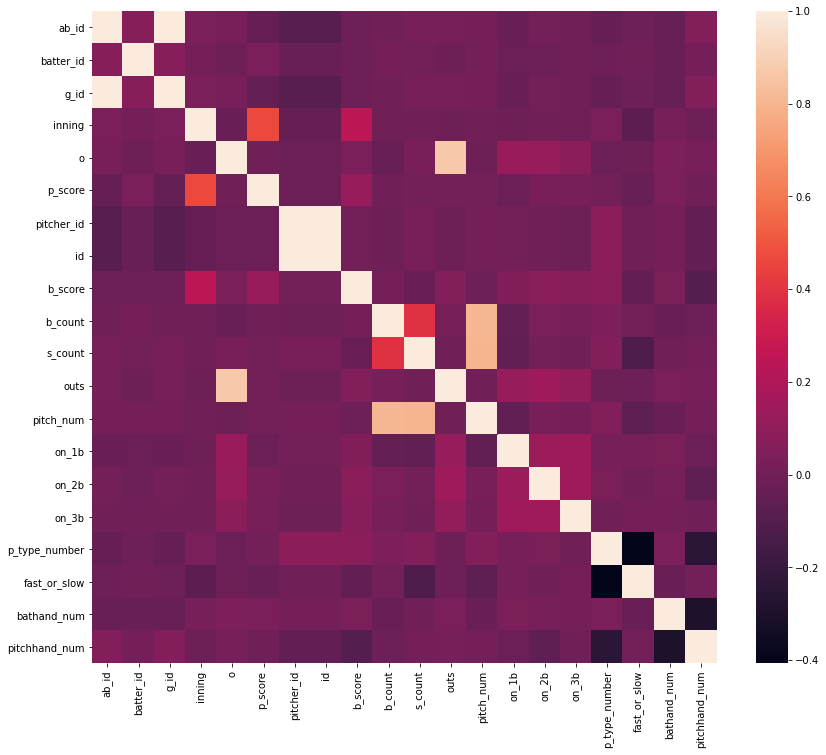

In [61]:
plt.subplots(figsize=(14,12))
sns.heatmap(data_num.corr());

In [58]:
data_num[data_num['fast_or_slow']==100].shape

(12650, 20)

In [59]:
data_num[data_num['fast_or_slow']!=100].shape

(8930, 20)

In [60]:
ratio = 12650/21580
ratio

0.5861909175162188

# Creating a baseline
simply guessing based on overall frequency would suggest that a pitch thrown in 2015 had a 54.8% chance of being a fastball. 



## Before proceding further, lets remove some features that are more for organizational purposes

These include pitcher_id, batter_id, g_id, and ab_id

In [39]:
dtest = data_num.drop(columns =['pitcher_id' , 'batter_id' , 'g_id', 'ab_id'])

### Scale the numerical data

In [41]:
scale_num_data = scale(dtest)

In [42]:
scale_num_data

array([[-1.41363168, -0.79187237, -0.73229365, ...,  0.84019572,
        -1.28356064, -1.08780816],
       [-1.41363168, -0.79187237, -0.73229365, ...,  0.84019572,
        -1.28356064, -1.08780816],
       [-1.41363168, -0.79187237, -0.73229365, ...,  0.84019572,
        -1.28356064, -1.08780816],
       ...,
       [ 0.00686772,  1.35655681, -0.73229365, ..., -1.19019887,
        -1.28356064,  0.91927974],
       [ 0.00686772,  1.35655681, -0.73229365, ..., -1.19019887,
        -1.28356064,  0.91927974],
       [ 0.00686772,  1.35655681, -0.73229365, ...,  0.84019572,
        -1.28356064,  0.91927974]])

In [43]:
#create a df with the scaled data
scaled_df = pd.DataFrame(scale_num_data, columns = dtest.columns)

In [44]:
scaled_df

,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,p_type_number,fast_or_slow,bathand_num,pitchhand_num
0,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,-1.127674,-1.200552,-1.094505,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
1,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,0.075550,-1.200552,-0.513075,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
2,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,1.278774,-1.200552,0.068354,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
3,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,1.278774,-1.200552,0.649784,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
4,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,0.211011,1.278774,-1.200552,1.231214,-0.560367,-0.407023,-0.266198,0.280949,-1.190199,-1.283561,-1.087808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0.006868,0.282342,-0.732294,2.115632,-0.698988,0.211011,1.278774,0.026265,0.649784,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,0.779083,0.919280
21576,0.006868,0.282342,-0.732294,2.115632,-0.698988,1.288537,1.278774,0.026265,1.231214,-0.560367,-0.407023,-0.266198,1.463720,-1.190199,0.779083,0.919280
21577,0.006868,1.356557,-0.732294,2.115632,-0.698988,-0.866515,-1.127674,1.253082,-1.094505,-0.560367,-0.407023,-0.266198,1.463720,-1.190199,-1.283561,0.919280
21578,0.006868,1.356557,-0.732294,2.115632,-0.698988,-0.866515,0.075550,1.253082,-0.513075,-0.560367,-0.407023,-0.266198,1.463720,-1.190199,-1.283561,0.919280


In [128]:
scaled_df.mean()

inning          -1.535239e-15
o                2.282285e-15
p_score         -2.982971e-15
id              -3.618154e-16
b_score         -2.550117e-16
b_count          4.852493e-16
s_count         -2.578970e-15
outs            -1.525337e-15
pitch_num       -4.437400e-15
on_1b           -2.411828e-16
on_2b            2.332554e-15
on_3b           -3.223336e-15
p_type_number   -5.533248e-15
bathand_num      1.004839e-15
pitchhand_num    4.164839e-15
dtype: float64

In [129]:
scaled_df.std()

inning           1.000023
o                1.000023
p_score          1.000023
id               1.000023
b_score          1.000023
b_count          1.000023
s_count          1.000023
outs             1.000023
pitch_num        1.000023
on_1b            1.000023
on_2b            1.000023
on_3b            1.000023
p_type_number    1.000023
bathand_num      1.000023
pitchhand_num    1.000023
dtype: float64

In [45]:
pitch_PCA = PCA().fit(scale_num_data)

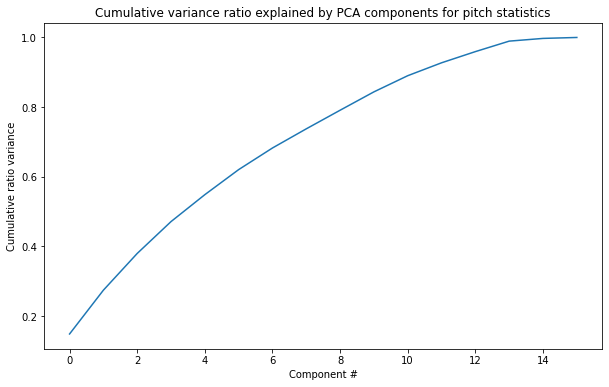

In [46]:
plt.subplots(figsize=(10, 6))
plt.plot(pitch_PCA.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for pitch statistics');

# Marker for log regression
https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html

In [47]:
dep = dtest[['fast_or_slow']]
indy = dtest.drop(columns = ['fast_or_slow'])

In [48]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(indy, dep, test_size = 0.25, random_state = 123)

In [49]:
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(16185, 15) (5395, 15) (16185, 1) (5395, 1)


In [50]:
Ytrain = np.ravel(Ytrain)
Ytest = np.ravel(Ytest)

In [51]:
logR = LogisticRegression()

In [52]:
logR.fit(Xtrain, Ytrain)

LogisticRegression()

In [53]:
logR.score(Xtrain, Ytrain)

0.5866543095458758

## logR score is 0.5866, almost exactly the baseline ratio

In [54]:
y_pred = logR.predict(Xtest)

In [55]:
print(y_pred)

[100 100 100 ... 100 100 100]


In [57]:
np.mean(y_pred)

100.0

## Narrow down our focus for now. 
Top, p_id, batter_id, pitcher_id, g_id for now can be removed, as we are just trying to gain a rudimentary idea of difference in correlation between features w breaking vs fastball pitches. 

In [28]:
fast1 = fast.drop(columns = ['pitcher_id' , 'batter_id' , 'g_id', 'top'])
breaking1 = breaking.drop(columns = ['pitcher_id' , 'batter_id' , 'g_id', 'top'])
fast1

In [23]:
type(fast1.corr())

pandas.core.frame.DataFrame

In [24]:
fast1.corr()

,ab_id,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,1.000000,0.024543,0.022000,-0.045467,-0.099389,-0.006660,0.006196,0.009554,0.010507,0.013227,-0.034396,0.012028,0.008138
inning,0.024543,1.000000,0.000465,0.482200,-0.024076,0.277544,0.026253,0.027639,0.009812,0.031501,-0.003016,0.024040,0.016114
o,0.022000,0.000465,1.000000,-0.003249,-0.021434,0.030030,-0.052868,0.030931,0.868600,-0.021286,0.139422,0.113967,0.086016
p_score,-0.045467,0.482200,-0.003249,1.000000,-0.017235,0.146717,0.013954,0.009163,0.010872,0.018686,-0.017342,0.033175,0.042732
id,-0.099389,-0.024076,-0.021434,-0.017235,1.000000,-0.008211,-0.009507,0.065047,-0.019844,0.039396,0.020346,0.003535,-0.010730
b_score,-0.006660,0.277544,0.030030,0.146717,-0.008211,1.000000,0.026162,-0.008709,0.058388,0.007690,0.069726,0.083909,0.075699
b_count,0.006196,0.026253,-0.052868,0.013954,-0.009507,0.026162,1.000000,0.394606,0.005449,0.816015,-0.038845,0.032586,0.024468
s_count,0.009554,0.027639,0.030931,0.009163,0.065047,-0.008709,0.394606,1.000000,0.014182,0.798104,-0.047320,0.021236,0.023596
outs,0.010507,0.009812,0.868600,0.010872,-0.019844,0.058388,0.005449,0.014182,1.000000,0.005745,0.131576,0.142565,0.122714
pitch_num,0.013227,0.031501,-0.021286,0.018686,0.039396,0.007690,0.816015,0.798104,0.005745,1.000000,-0.053564,0.032521,0.029364


In [30]:
breaking1.corr()

,ab_id,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,1.000000,0.040016,0.028768,-0.030061,-0.055574,-0.016791,-0.019030,0.027012,0.023258,0.013699,-0.009299,-0.005002,-0.013568
inning,0.040016,1.000000,-0.057824,0.439900,-0.051940,0.206999,-0.031848,-0.062329,-0.048374,-0.052153,-0.029806,-0.023830,-0.031612
o,0.028768,-0.057824,1.000000,-0.001444,-0.008735,0.027899,0.002744,0.009450,0.873568,-0.002795,0.122856,0.136272,0.066044
p_score,-0.030061,0.439900,-0.001444,1.000000,-0.026245,0.102497,-0.008853,-0.003709,-0.001384,-0.008247,-0.023939,0.010923,-0.007372
id,-0.055574,-0.051940,-0.008735,-0.026245,1.000000,0.035654,-0.021364,-0.022089,0.002261,-0.012016,-0.012215,-0.003889,-0.016195
b_score,-0.016791,0.206999,0.027899,0.102497,0.035654,1.000000,0.002493,-0.060259,0.059197,-0.036780,0.031202,0.076014,0.073340
b_count,-0.019030,-0.031848,0.002744,-0.008853,-0.021364,0.002493,1.000000,0.385616,0.032862,0.797267,-0.040302,0.025343,0.015081
s_count,0.027012,-0.062329,0.009450,-0.003709,-0.022089,-0.060259,0.385616,1.000000,-0.023069,0.795805,-0.050602,-0.020155,-0.024383
outs,0.023258,-0.048374,0.873568,-0.001384,0.002261,0.059197,0.032862,-0.023069,1.000000,-0.001941,0.112643,0.159684,0.095063
pitch_num,0.013699,-0.052153,-0.002795,-0.008247,-0.012016,-0.036780,0.797267,0.795805,-0.001941,1.000000,-0.050438,0.005701,-0.003990


# lets look for differences in corr by subtracting the two


In [51]:
subtract = fast1.corr().subtract(breaking1.corr())
subtract

,ab_id,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,0.000000,-0.015474,-0.006767,-0.015406,-0.043815,0.010131,0.025226,-0.017459,-0.012750,-0.000472,-0.025098,0.017030,0.021706
inning,-0.015474,0.000000,0.058289,0.042300,0.027863,0.070545,0.058101,0.089969,0.058186,0.083653,0.026790,0.047870,0.047725
o,-0.006767,0.058289,0.000000,-0.001805,-0.012699,0.002131,-0.055612,0.021481,-0.004967,-0.018491,0.016566,-0.022306,0.019972
p_score,-0.015406,0.042300,-0.001805,0.000000,0.009010,0.044219,0.022807,0.012871,0.012256,0.026933,0.006597,0.022252,0.050103
id,-0.043815,0.027863,-0.012699,0.009010,0.000000,-0.043866,0.011857,0.087135,-0.022105,0.051412,0.032561,0.007424,0.005464
b_score,0.010131,0.070545,0.002131,0.044219,-0.043866,0.000000,0.023669,0.051550,-0.000810,0.044470,0.038524,0.007895,0.002358
b_count,0.025226,0.058101,-0.055612,0.022807,0.011857,0.023669,0.000000,0.008989,-0.027413,0.018748,0.001457,0.007244,0.009387
s_count,-0.017459,0.089969,0.021481,0.012871,0.087135,0.051550,0.008989,0.000000,0.037250,0.002299,0.003282,0.041391,0.047979
outs,-0.012750,0.058186,-0.004967,0.012256,-0.022105,-0.000810,-0.027413,0.037250,0.000000,0.007686,0.018933,-0.017119,0.027651
pitch_num,-0.000472,0.083653,-0.018491,0.026933,0.051412,0.044470,0.018748,0.002299,0.007686,0.000000,-0.003126,0.026821,0.033354


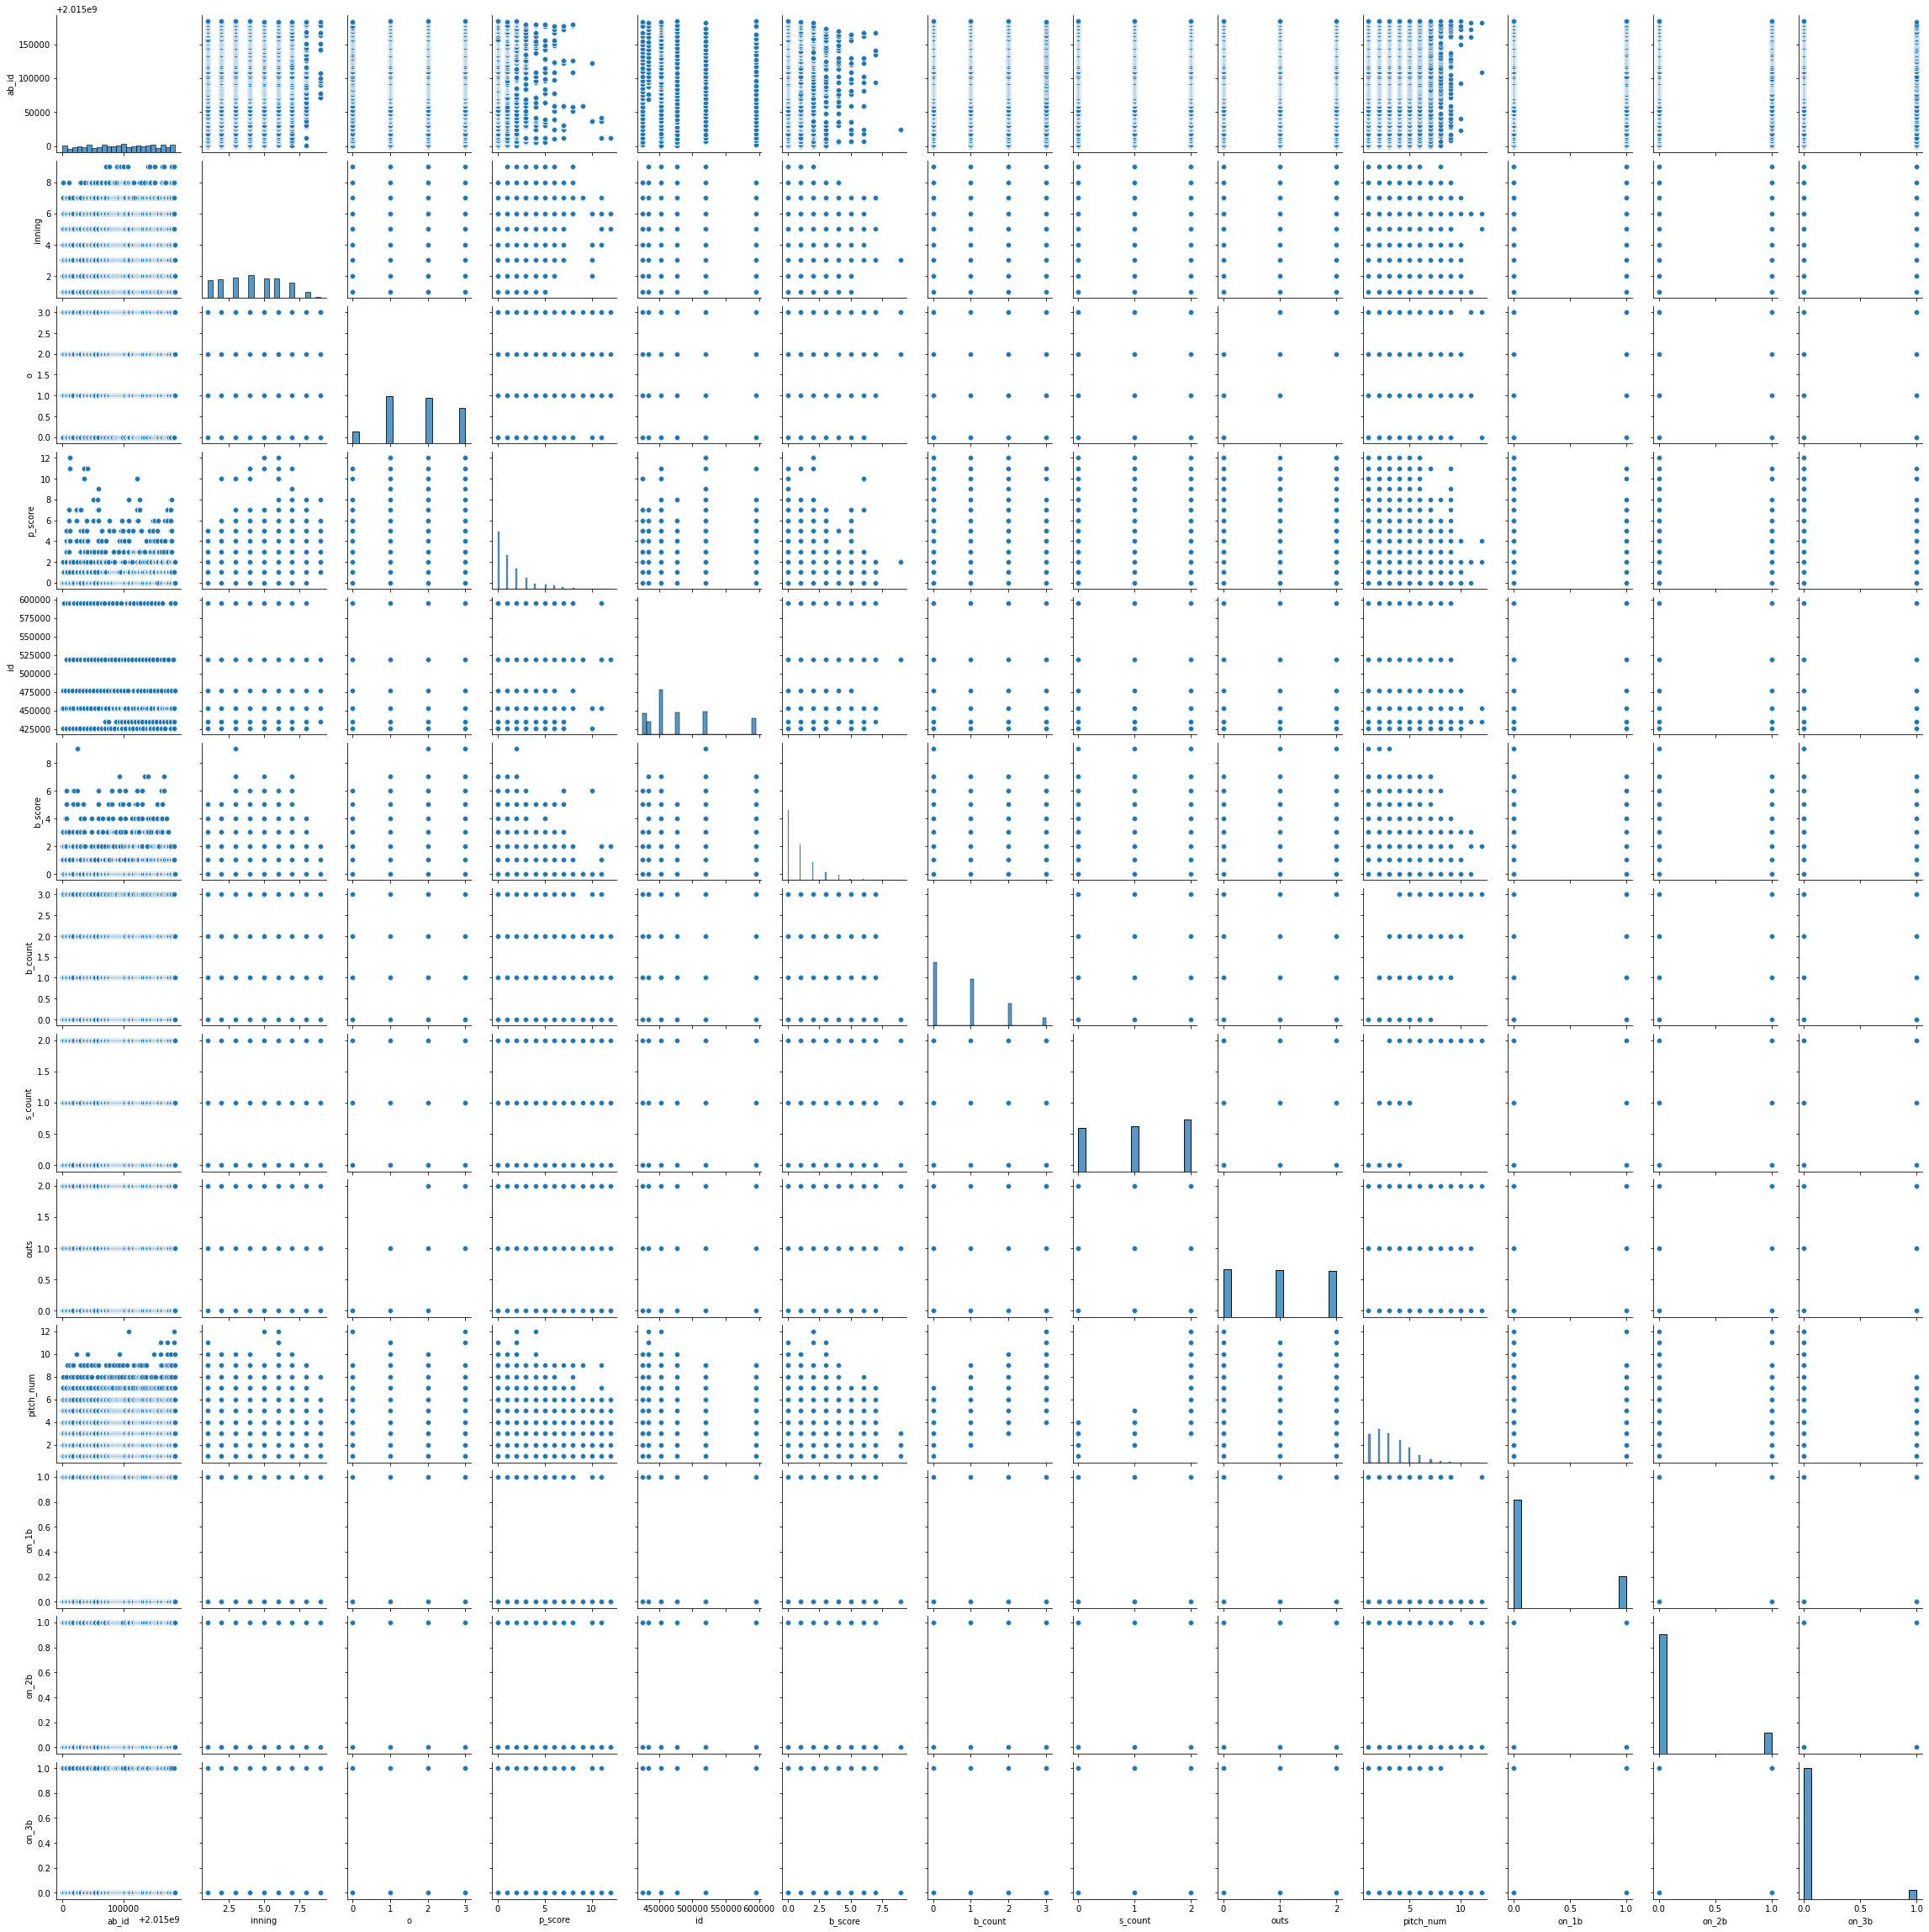

In [31]:
sns.pairplot(breaking1)

In [43]:
ffast = pd.DataFrame(data[data.pitch_type.isin(['FF', 'FT'])])
temp = [1 for x in range(len(ffast))]
ffast['pitch'] = temp

bbreaking =pd.DataFrame(data[~data.pitch_type.isin(['FF', 'FT'])])
temp2 = [0 for x in range(len(bbreaking))]
bbreaking['pitch'] = temp2

In [44]:
ffast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11836 entries, 0 to 21601
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ab_id       11836 non-null  int64  
 1   batter_id   11836 non-null  int64  
 2   event       11836 non-null  object 
 3   g_id        11836 non-null  int64  
 4   inning      11836 non-null  int64  
 5   o           11836 non-null  int64  
 6   p_score     11836 non-null  int64  
 7   p_throws    11836 non-null  object 
 8   pitcher_id  11836 non-null  int64  
 9   stand       11836 non-null  object 
 10  top         11836 non-null  bool   
 11  id          11836 non-null  int64  
 12  last_name   11836 non-null  object 
 13  date        11836 non-null  object 
 14  type        11836 non-null  object 
 15  pitch_type  11836 non-null  object 
 16  b_score     11836 non-null  float64
 17  b_count     11836 non-null  float64
 18  s_count     11836 non-null  float64
 19  outs        11836 non-nul

In [47]:
data2 = pd.concat([ffast, bbreaking])
data2.describe()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitch
count,2.160200e+04,21602.000000,2.160200e+04,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000
mean,2.015095e+09,494408.535784,2.015013e+08,3.985187,1.737247,1.427970,480563.939867,480563.939867,0.889408,0.804648,0.936673,0.979122,2.882279,0.238959,0.142579,0.066244,0.547912
std,5.243495e+04,84185.384730,6.922723e+02,2.111705,0.930645,1.950648,54038.089424,54038.089424,1.271358,0.928528,0.831183,0.815218,1.719559,0.426458,0.349651,0.248714,0.497711
min,2.015000e+09,112526.000000,2.015000e+08,1.000000,0.000000,0.000000,425844.000000,425844.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.015051e+09,452239.000000,2.015007e+08,2.000000,1.000000,0.000000,452657.000000,452657.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.015097e+09,500208.000000,2.015013e+08,4.000000,2.000000,1.000000,453286.000000,453286.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,2.015140e+09,546318.000000,2.015019e+08,6.000000,2.000000,2.000000,519242.000000,519242.000000,1.000000,1.000000,2.000000,2.000000,4.000000,0.000000,0.000000,0.000000,1.000000
max,2.015184e+09,648717.000000,2.015024e+08,9.000000,3.000000,12.000000,594798.000000,594798.000000,9.000000,4.000000,2.000000,2.000000,13.000000,1.000000,1.000000,1.000000,1.000000


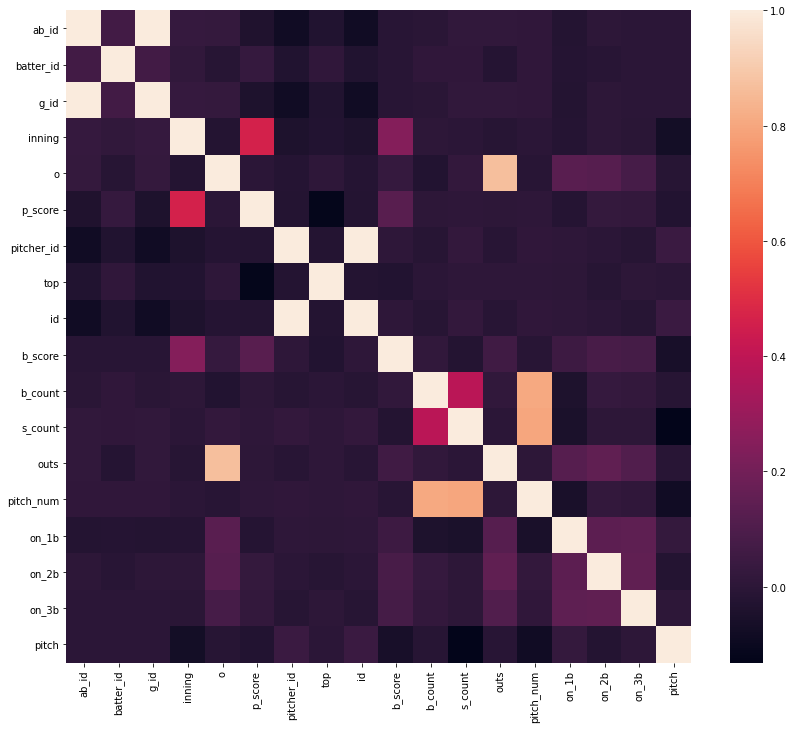

In [46]:
plt.subplots(figsize=(14,12))
sns.heatmap(data2.corr());

In [25]:
fast = data[data.pitch_type.isin(['FF', 'FT'])]

breaking = data[~data.pitch_type.isin(['FF', 'FT'])]

In [26]:
fast.pitch_type.value_counts()

FF    9201
FT    2635
Name: pitch_type, dtype: int64

In [27]:
breaking.pitch_type.value_counts()

SL    3637
CH    2667
CU    2282
FC     814
SI     344
IN      13
EP       4
PO       2
FA       2
FS       1
Name: pitch_type, dtype: int64

## Can covert this into a function to subset data on counts

In [41]:
data15clean=data

In [ ]:
def count_subset(df):
    for i in range(3):
        for j in range(4):
            df[np.logical_and(df.loc[:, 's_count'].astype(int) == i) , \
              df.loc[:, 'b_count'].astype(int) == j]
            